# -------------------------------------------------------------
# Advance computing techniques - EPFL 2018
# -------------------------------------------------------------

# Flavours of Physics: Finding τ → μμμ
The idea for this final project is to implement a solution for this (closed) Kaggle competition, organized by the LHCb experiment, where the main goal is to identify rare decays, not yet observed in any experiment, but with huge potential impact for the HEP community in case of discovery.
https://www.kaggle.com/c/flavours-of-physics/

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn import cross_validation, learning_curve, metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import evaluation


/home/jhoya/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/jhoya/.local/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Read training data

All data files can be downloaded from the following link and stored in the local folder: 'tau_data/'
https://www.kaggle.com/c/flavours-of-physics/data

In [2]:
folder = 'tau_data/'
train = pd.read_csv(folder + 'training.csv', index_col='id')

In [3]:
train.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
id,,,,,,,,,,,,,,,,,,,,,
18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


# Separating Signal and Background

In [4]:
train_sig = train[train.signal != 0]
train_bkg = train[train.signal == 0]
train_sig.head()
#train_bkg.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
id,,,,,,,,,,,,,,,,,,,,,
12688485,0.000646,1.000000,8.926965,0.492301,0.005492,0.499725,7.137887,5292.564941,0.030779,0.113535,...,52840.578125,5170.989746,3.528924,3.317357,3.504919,292,1,1,1774.747314,0.053224
7966980,0.000367,0.999961,1.636600,0.170529,0.014811,1.084020,1.096192,3482.666504,0.020872,0.003182,...,12938.986328,6189.572754,2.463624,2.634690,2.759173,321,1,1,1778.506592,0.853014
2161057,0.002084,0.999995,16.603760,0.286042,0.052418,4.230888,4.359327,4381.862305,0.023184,0.023793,...,17749.755859,16051.432617,2.966415,2.896673,3.173078,115,1,1,1785.900024,0.728033
6669435,0.001371,0.999994,9.925543,0.169947,0.033973,2.297005,0.780279,6534.743652,0.010817,0.011853,...,20643.656250,13227.011719,2.740902,2.615249,2.338443,164,1,1,1770.792114,0.288036
5227799,0.001125,0.999988,30.399183,1.784555,0.140386,7.995636,5.465528,4277.039062,0.195418,0.042225,...,121556.132812,31639.568359,3.630409,4.224084,4.660987,274,4,1,1742.513184,0.068925


In [6]:
# Dropping mass, signal, production and min_ANNmuon variables that are not in the test sample
df_train_sig = train_sig.drop(['production', 'signal', 'mass', 'min_ANNmuon'], axis=1)
df_train_sig.head()
df_train_bkg = train_bkg.drop(['production', 'signal', 'mass', 'min_ANNmuon'], axis=1)
df_train_bkg.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
id,,,,,,,,,,,,,,,,,,,,,
18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,...,353.819733,448.369446,1393.246826,3842.096436,12290.760742,39264.398438,3.076006,4.003800,4.031514,458
5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,...,656.524902,2033.918701,747.137024,8299.368164,16562.667969,7341.257812,3.228553,2.786543,2.975564,406
11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,...,658.523743,2576.380615,963.652466,11323.134766,22695.388672,10225.309570,3.536903,2.865686,3.052810,196
15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,...,1047.216187,1351.734131,1685.003662,11502.081055,16909.515625,9141.426758,3.087461,3.218034,2.375592,137
1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,...,1442.538208,1755.792236,1282.428711,74117.117188,97612.804688,47118.785156,4.632295,4.711155,4.296878,477



# Cheking the variables

In [7]:
# Baseline variables
variables = ['LifeTime',
             'FlightDistance',
             'pt',
            ]
#'pearson', 'kendall', 'spearman'
df_train_sig[variables].corr(method='kendall', min_periods=1)
#df_train_bkg[variables].corr(method='pearson', min_periods=1)

,LifeTime,FlightDistance,pt
LifeTime,1.00000,0.454820,-0.138010
FlightDistance,0.45482,1.000000,0.127066
pt,-0.13801,0.127066,1.000000


In [8]:
all_variables = list( df_train_sig.columns.values )
print (all_variables)
print(len(all_variables))


['LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP', 'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree', 'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3', 'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP', 'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p', 'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits']
46


/home/jhoya/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

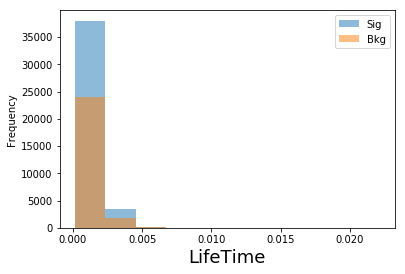

<Figure size 432x288 with 0 Axes>

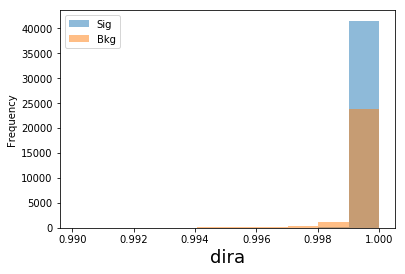

<Figure size 432x288 with 0 Axes>

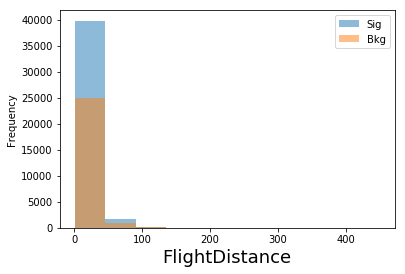

<Figure size 432x288 with 0 Axes>

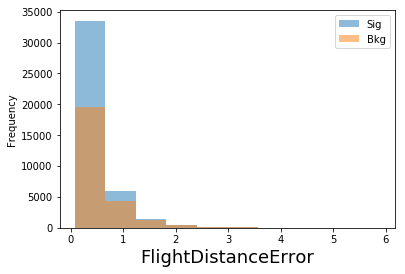

<Figure size 432x288 with 0 Axes>

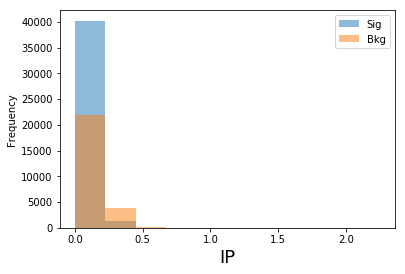

<Figure size 432x288 with 0 Axes>

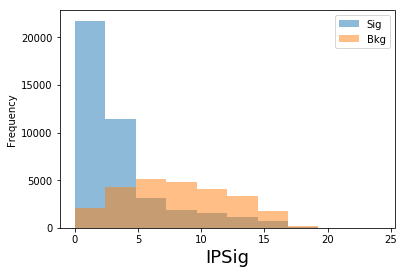

<Figure size 432x288 with 0 Axes>

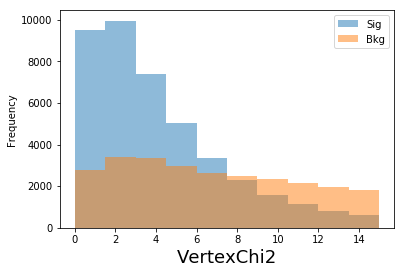

<Figure size 432x288 with 0 Axes>

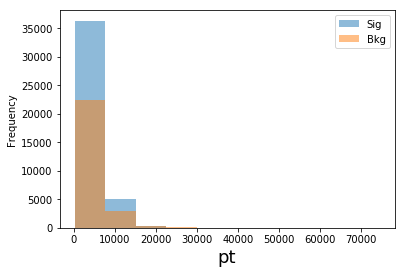

<Figure size 432x288 with 0 Axes>

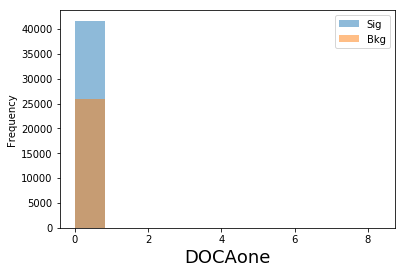

<Figure size 432x288 with 0 Axes>

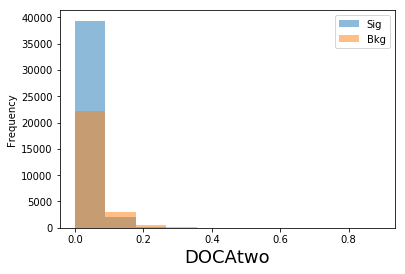

<Figure size 432x288 with 0 Axes>

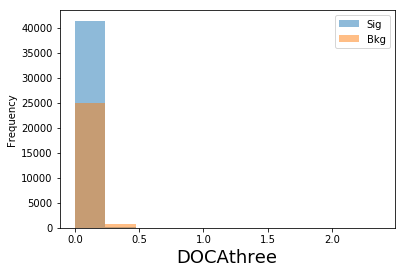

<Figure size 432x288 with 0 Axes>

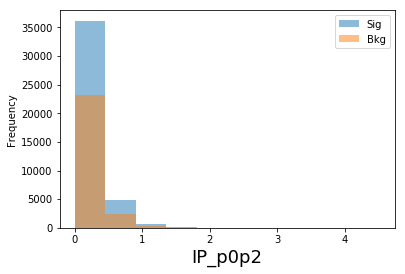

<Figure size 432x288 with 0 Axes>

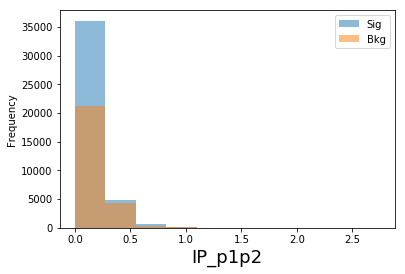

<Figure size 432x288 with 0 Axes>

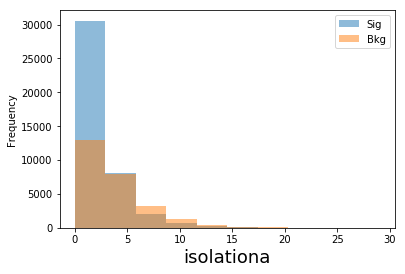

<Figure size 432x288 with 0 Axes>

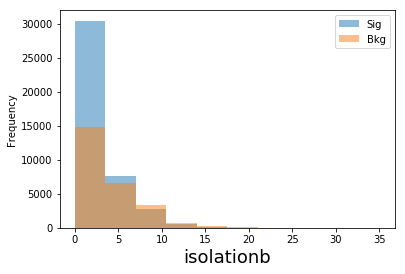

<Figure size 432x288 with 0 Axes>

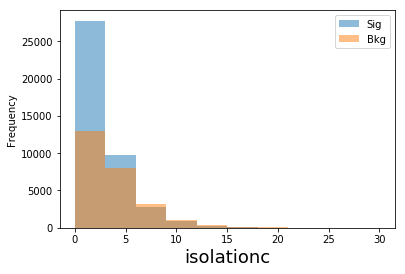

<Figure size 432x288 with 0 Axes>

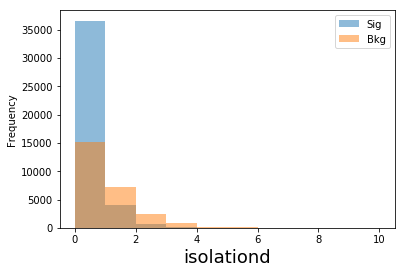

<Figure size 432x288 with 0 Axes>

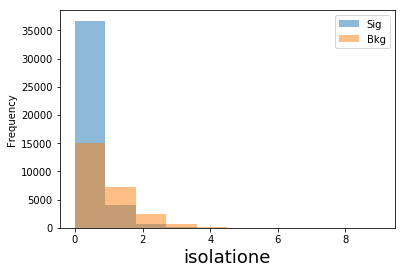

<Figure size 432x288 with 0 Axes>

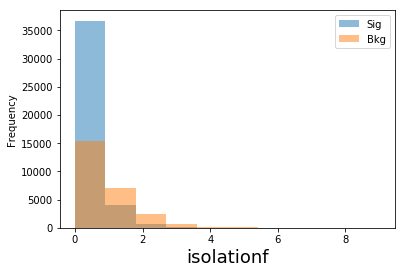

<Figure size 432x288 with 0 Axes>

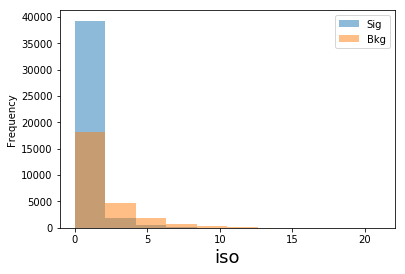

<Figure size 432x288 with 0 Axes>

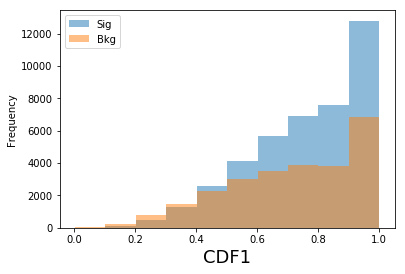

<Figure size 432x288 with 0 Axes>

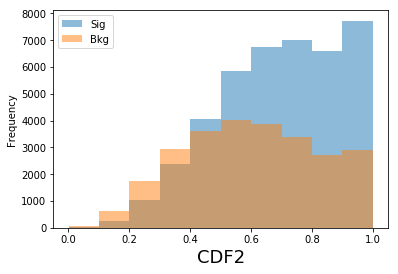

<Figure size 432x288 with 0 Axes>

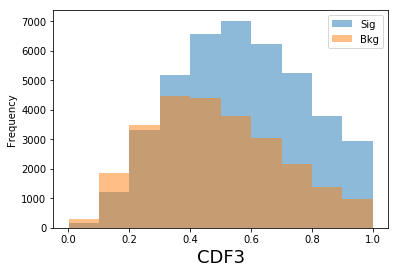

<Figure size 432x288 with 0 Axes>

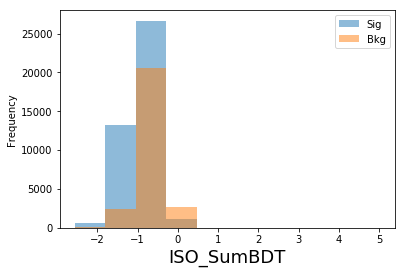

<Figure size 432x288 with 0 Axes>

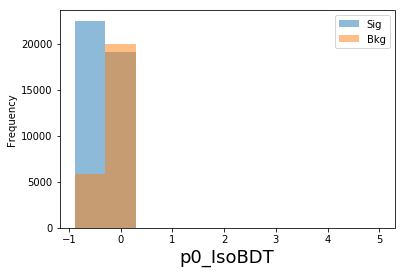

<Figure size 432x288 with 0 Axes>

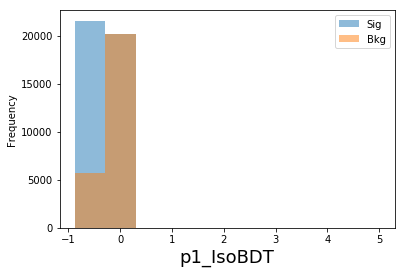

<Figure size 432x288 with 0 Axes>

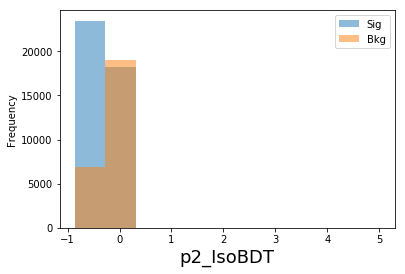

<Figure size 432x288 with 0 Axes>

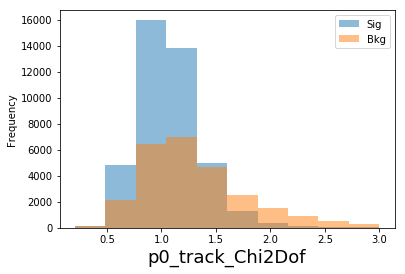

<Figure size 432x288 with 0 Axes>

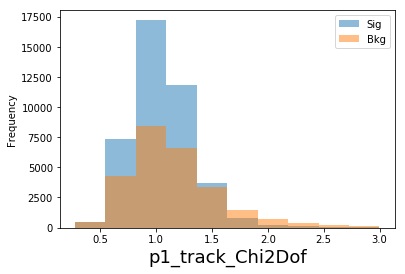

<Figure size 432x288 with 0 Axes>

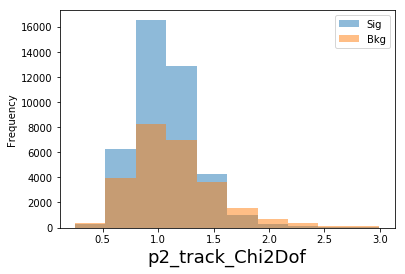

<Figure size 432x288 with 0 Axes>

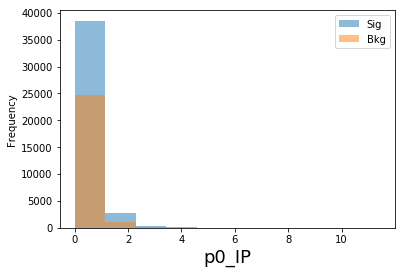

<Figure size 432x288 with 0 Axes>

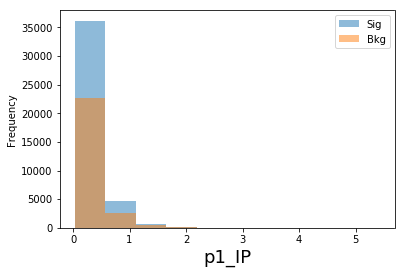

<Figure size 432x288 with 0 Axes>

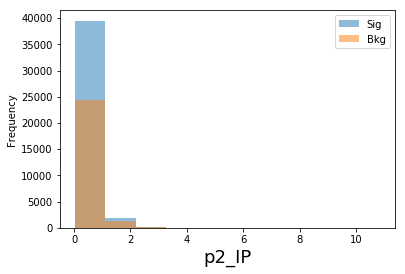

<Figure size 432x288 with 0 Axes>

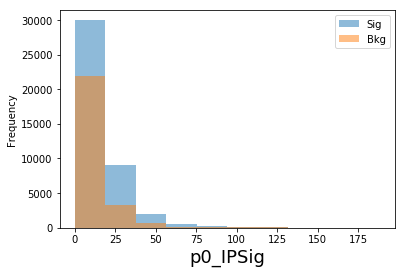

<Figure size 432x288 with 0 Axes>

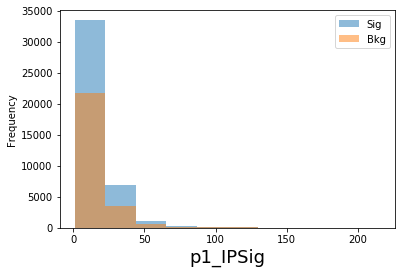

<Figure size 432x288 with 0 Axes>

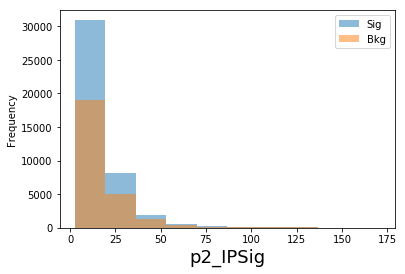

<Figure size 432x288 with 0 Axes>

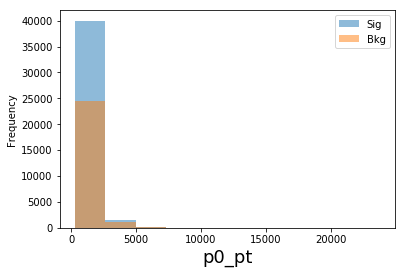

<Figure size 432x288 with 0 Axes>

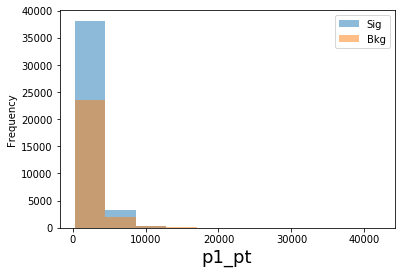

<Figure size 432x288 with 0 Axes>

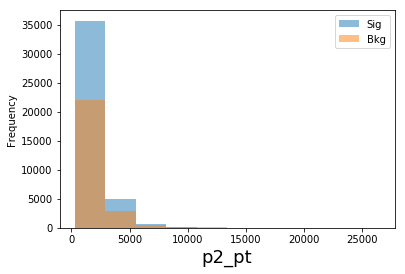

<Figure size 432x288 with 0 Axes>

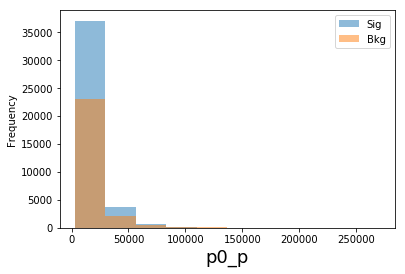

<Figure size 432x288 with 0 Axes>

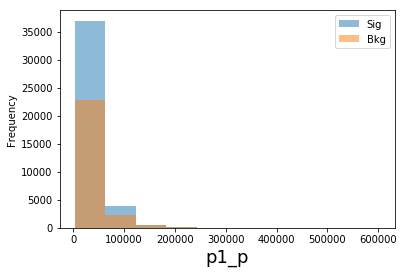

<Figure size 432x288 with 0 Axes>

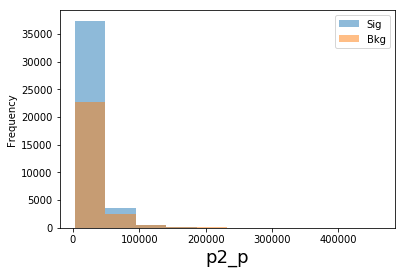

<Figure size 432x288 with 0 Axes>

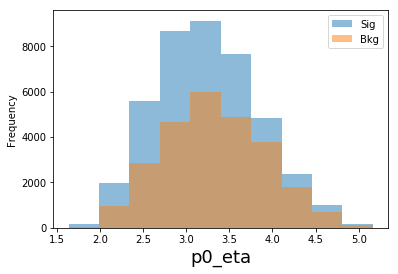

<Figure size 432x288 with 0 Axes>

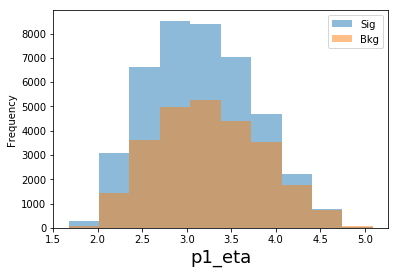

<Figure size 432x288 with 0 Axes>

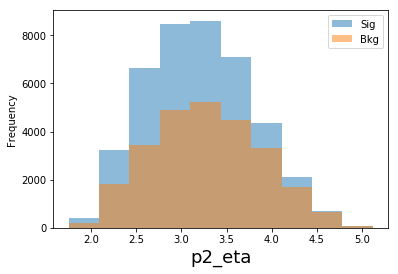

<Figure size 432x288 with 0 Axes>

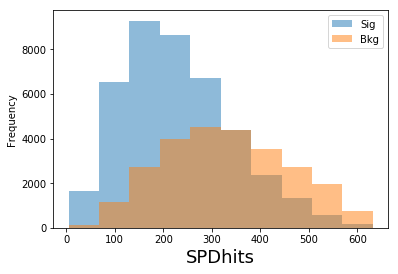

In [9]:
for var in all_variables:
    df2 = pd.DataFrame( {'Sig': df_train_sig[var], 'Bkg': df_train_bkg[var] }, columns=['Sig', 'Bkg'])
    plt.figure();
    df2.plot.hist(alpha=0.5)
    plt.xlabel(var, fontsize=18)

In [10]:
# Most discriminating variables:
dis_vars = ['LifeTime', 'IPSig', 'VertexChi2','pt', 'CDF2', 'CDF3',
            'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT',] #'SPDhits'

This set of variables are at "first sight" the most discriminating variables from all the ones we have. Of course we're missing many things with only checking the distributions for signal and background, but it is a first starting point.

NOTE: Something to investigate is the variable SPDhits. From checking the plot, one might suspect this is a good variable to use, but after using it, we do not pass the "Agreement" test. See below.

# Correlation between the discrimination variables

Just from the knowledge we have of these variables, we already know that many of them will be highly correlated. The idea then is to check the correlation and decide which of these variables could be dropped.

In [11]:
#'pearson', 'kendall', 'spearman'
df_train_sig[dis_vars].corr(method='kendall', min_periods=1)
df_train_bkg[dis_vars].corr(method='pearson', min_periods=1)

,LifeTime,IPSig,VertexChi2,pt,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT
LifeTime,1.000000,0.212997,-0.070231,-0.130955,0.042055,-0.046758,-0.013968,-0.012296,-0.014141,-0.011525
IPSig,0.212997,1.000000,0.016837,0.060768,0.072447,0.046741,0.051716,0.058144,0.036479,0.045521
VertexChi2,-0.070231,0.016837,1.000000,-0.086923,-0.074554,-0.075281,-0.020450,-0.028428,-0.011269,-0.011947
pt,-0.130955,0.060768,-0.086923,1.000000,0.268216,0.325128,0.073154,0.072108,0.055989,0.057957
CDF2,0.042055,0.072447,-0.074554,0.268216,1.000000,0.815092,-0.244337,-0.201868,-0.218763,-0.213826
CDF3,-0.046758,0.046741,-0.075281,0.325128,0.815092,1.000000,-0.276534,-0.231096,-0.243318,-0.240387
ISO_SumBDT,-0.013968,0.051716,-0.020450,0.073154,-0.244337,-0.276534,1.000000,0.883972,0.889779,0.874491
p0_IsoBDT,-0.012296,0.058144,-0.028428,0.072108,-0.201868,-0.231096,0.883972,1.000000,0.740430,0.694384
p1_IsoBDT,-0.014141,0.036479,-0.011269,0.055989,-0.218763,-0.243318,0.889779,0.740430,1.000000,0.721957
p2_IsoBDT,-0.011525,0.045521,-0.011947,0.057957,-0.213826,-0.240387,0.874491,0.694384,0.721957,1.000000


Some of these variables are highly correlated, like the pX_IsoBDT and ISO_SumBDT, or CDF2 and CDF3, so they are candidates to be removed. For the moment, we will work with all of them.

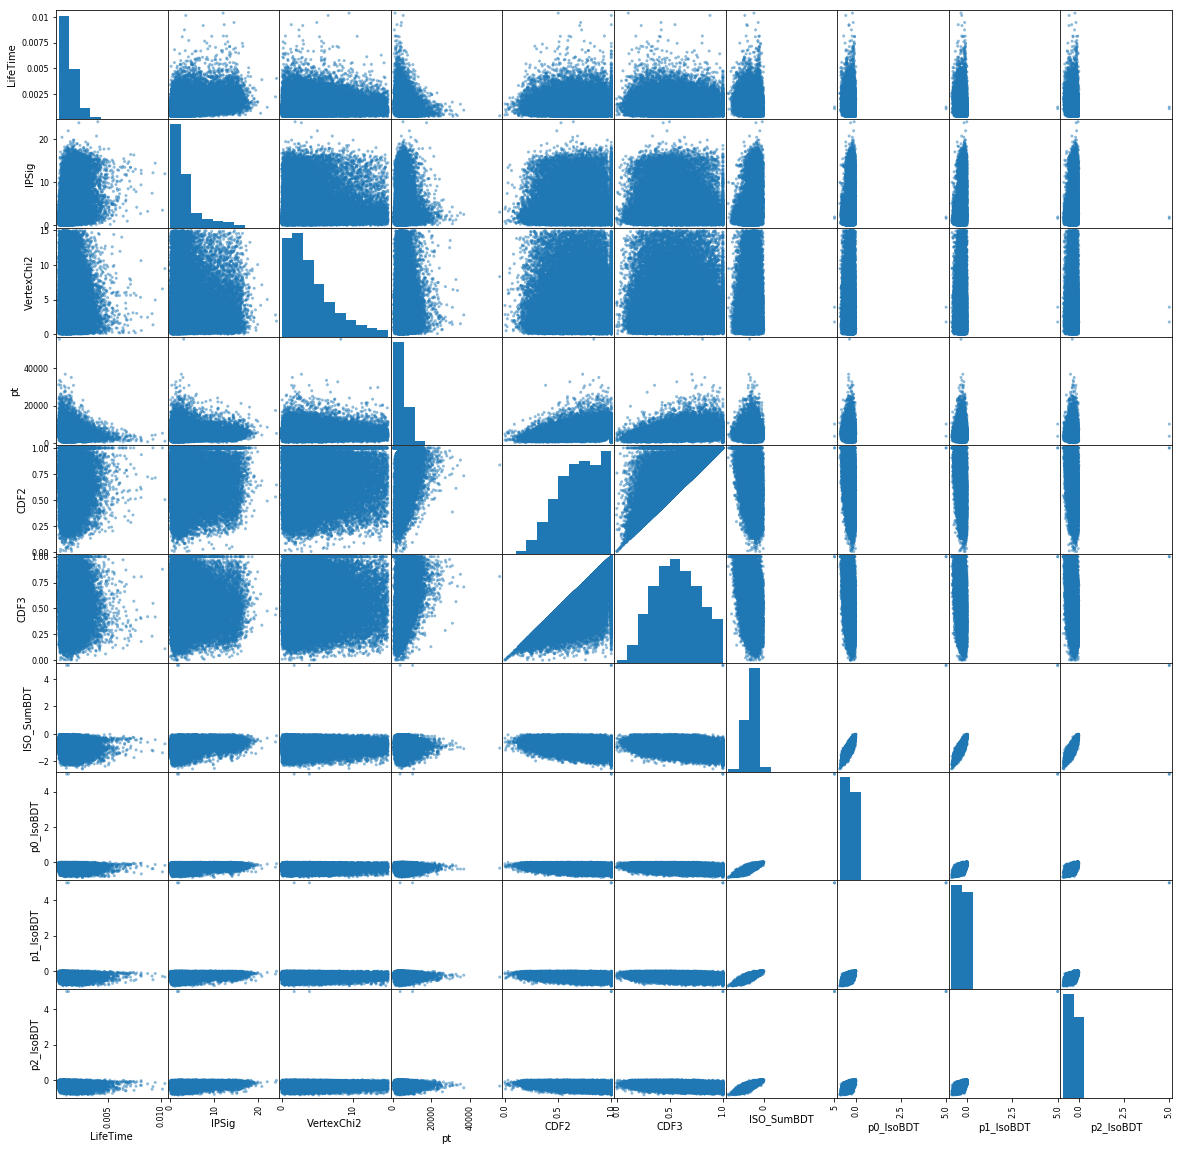

In [12]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_train_sig[dis_vars], figsize=(20,20))
plt.show()

# Searching for the best parameters for 4 different classifiers

NOTE: Everything is commented out, because this is one of the most time consuming steps

In [13]:
from sklearn.model_selection import GridSearchCV

## RandomForestClassifier
#rfc_clf = RandomForestClassifier(  n_estimators = 100, random_state = 10 )
## AdaBoostClassifier
#abc_clf = AdaBoostClassifier( n_estimators = 100, random_state = 11 )
## GradientBoostingClassifier
#gbc_clf = GradientBoostingClassifier(  n_estimators = 100, max_features = 'auto', subsample=0.7, random_state=12 )
#XGBoostClassifier
#xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state = 13)


parameters_rfc = {
    'criterion'        : ['gini', 'entropy'],
    'n_estimators'     : np.arange(100,220,30),
    'max_depth'        : [6,14,2],
    'min_samples_leaf' : np.arange(6,12,2)
}

parameters_abc = {
    'learning_rate'    : [0.05, 0.1, 0.15, 0.2],
    'n_estimators'     : np.arange(100,220,30),
}

parameters_gbc = {
    'learning_rate'    : [0.01, 0.05, 0.1, 0.15],
    'n_estimators'     : np.arange(100,220,30),
    'max_depth'        : [6,14,2],
    'min_samples_leaf' : np.arange(6,12,2)
}

parameters_xgb = {
    'learning_rate'    : [0.05, 0.1, 0.2, 0.5],
    'n_estimators'     : np.arange(150,300,50),
    'max_depth'        : [6,10,2],
}

#rfc_gscv = GridSearchCV( rfc_clf, param_grid = parameters_rfc, cv = 3, n_jobs=3 )
#abc_gscv = GridSearchCV( abc_clf, param_grid = parameters_abc, cv = 3 )
#gbc_gscv = GridSearchCV( gbc_clf, param_grid = parameters_gbc, cv = 3 )
#xgb_gscv = GridSearchCV( xgb_clf, param_grid = parameters_xgb, cv = 3, n_jobs=3)

#rfc_gscv.fit(train[dis_vars], train['signal'])
#abc_gscv.fit(train[dis_vars], train['signal'])
#gbc_gscv.fit(train[dis_vars], train['signal'])
#xgb_gscv.fit(train[dis_vars], train['signal'])

#rfc_clf_best = rfc_gscv.best_estimator_
#abc_clf_best = abc_gscv.best_estimator_
#gbc_clf_best = gbc_gscv.best_estimator_
#xgb_clf_best = xgb_gscv.best_estimator_

#print('#############')
#print('Random Forest Classifier')
#print('#############')
#print(rfc_gscv.best_params_)
#print("Best score for RFC: ", rfc_clf_best.score(train[dis_vars], train['signal']))

#print('#############')
#print('AdaBoost Classifier')
#print('#############')
#print(abc_gscv.best_params_)
#print("Best score for ABC: ", abc_clf_best.score(train[dis_vars], train['signal']))

#print('#############')
#print('Gradient Boosting Classifier')
#print('#############')
#print(gbc_gscv.best_params_)
#print("Best score for GBC: ", gbc_clf_best.score(train[dis_vars], train['signal']))

#print('#############')
#print('XGBoost Classifier')
#print('#############')
#print(xgb_gscv.best_params_)
#print("Best score for XGB: ", xgb_clf_best.score(train[dis_vars], train['signal']))

# Classifiers training - With the best parameters

All the parameters used in the next few lines were the best ones that the GridSearchCV found.

In [14]:
# Baseline
baseline = GradientBoostingClassifier( n_estimators = 40, learning_rate = 0.01, subsample = 0.7,
                                       min_samples_leaf = 10, max_depth = 7, random_state = 11  )
baseline.fit(train[variables], train['signal'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=11, subsample=0.7, verbose=0,
              warm_start=False)

In [15]:
# RandomForestClassifier
rfc_best_clf = RandomForestClassifier(  n_estimators = 160, max_depth = 10, min_samples_leaf = 8, random_state = 11 )
rfc_best_clf.fit(train[dis_vars], train['signal'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
            oob_score=False, random_state=11, verbose=0, warm_start=False)

In [16]:
# AdaBoostClassifier
abc_best_clf = AdaBoostClassifier( n_estimators = 160, learning_rate = 0.1, random_state = 11 )
abc_best_clf.fit(train[dis_vars], train['signal'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=160, random_state=11)

In [17]:
# GradientBoostingClassifier
gbc_best_clf = GradientBoostingClassifier( n_estimators = 80, learning_rate = 0.05, subsample = 0.7,
                                           min_samples_leaf = 6, max_depth = 6, random_state = 11   )
gbc_best_clf.fit(train[dis_vars], train['signal'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=6, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=11, subsample=0.7, verbose=0,
              warm_start=False)

In [18]:
# XGBoostClassifier
xgb_best_clf = xgb.XGBClassifier( n_estimators = 250, learning_rate = 0.2, subsample = 0.7,
                                  max_depth = 6, random_state = 11   )
xgb_best_clf.fit(train[dis_vars], train['signal'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=11, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

# Check agreement test


[TEXT FROM THE ORGANIZERS]

Classifier should agree on real and simulated data.

Since the classifier is trained on a mix of simulated signal and real data background, it is possible to reach a high performance by picking features that are not perfectly modeled in the simulation. We require that the classifier not have a large discrepancy when applied to real and simulated data.

To verify this, we use a control channel, Ds → φπ, that has a similar topology as the signal decay, τ → 3μ. Ds → φπ is a much more well-known, well-observed behavior, as it happens more frequently. We provide both data and simulation samples for this decay, to which the classifier is applied. A Kolmogorov–Smirnov (KS) test is used to evaluate the differences between the classifier distribution on each sample.

Ds → φπ data is not included in the training set. This control channel data is used purely in the test set as "ignored" data, meaning that they don’t contribute to the final scoring. The control channel dataset is used purely in Kolmogorov–Smirnov test. We require the KS-value of the test to be smaller than 0.09. Only when a submission can pass the agreement test on these ignored data, we can then regard the predictions as valid, and score on the submission.

In particle physics experiments, it is well-known how to split the signal/background by their “weights”. The method is called sPlot. This weight is a measurement derived from the likelihood/probability that the event is a Ds → φπ and the weights range from -∞ to ∞. Higher weight means likely this event is signal, lower weights means it’s likely to be background. 

The Control channel, Ds → φπ, is split into two main parts, real (data1) and simulated (data2): 

    data1 = real data with weight from sPlot function and signal = 0
    data2 = simulated data (just signal) with weight = 1 and signal = 1

We use K-S test to tell that classifier outputs for data1 and data2 are from the same distribution.

In [19]:
# Baseline
check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
agreement_probs = baseline.predict_proba(check_agreement[variables])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric for baseline: ', ks, ks < 0.09)

KS metric for baseline:  0.06817055962389801 True


In [20]:
# RandomForestClassifier
check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
agreement_probs = rfc_best_clf.predict_proba(check_agreement[dis_vars])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric for the RandomForestClassifier: ', ks, ks < 0.09)

KS metric for the RandomForestClassifier:  0.04893818138371442 True


In [21]:
# AdaBoostClassifier
check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
agreement_probs = abc_best_clf.predict_proba(check_agreement[dis_vars])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric for the AdaBoostClassifier: ', ks, ks < 0.09)

KS metric for the AdaBoostClassifier:  0.04956211022799362 True


In [22]:
# GradientBoostingClassifier
check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
agreement_probs = gbc_best_clf.predict_proba(check_agreement[dis_vars])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric for the GradientBoostingClassifier: ', ks, ks < 0.09)

KS metric for the GradientBoostingClassifier:  0.049809853225925904 True


In [23]:
# XGBoostClassifier
check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
agreement_probs = xgb_best_clf.predict_proba(check_agreement[dis_vars])[:, 1]

ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric for the XGBoostClassifier: ', ks, ks < 0.09)

KS metric for the XGBoostClassifier:  0.040174986806259194 True


All the classifiers successfully passed this test, being the XGBClassifier the one with smallest KS value: ~0.040

# Check correlation test

[TEXT FROM THE ORGANIZERS]

Model should be uncorrelated to the τ mass.
Correlations with mass can cause an artificial signal-like mass peak or lead to incorrect background estimations. 

The mass column is not included in the test dataset. However, we use the hidden mass information to perform a Cramer-von Mises (cvm) test. This test iteratively compares two distributions of a) predicted values from submission for entire dataset and b) predicted values within a certain mass region in rolling window fashion along the whole mass range. Then we get average value for those checks. Getting similar distributions for all mass sub-regions means that your classifier is not correlated with the mass. Your submission must give a cvm value less than 0.002 to pass the test. 

In [24]:
# Baseline
check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
correlation_probs = baseline.predict_proba(check_correlation[variables])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric for baseline', cvm, cvm < 0.002)

CvM metric for baseline 0.0009815093549143013 True


In [25]:
# RandomForestClassifier
check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
correlation_probs = rfc_best_clf.predict_proba(check_correlation[dis_vars])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric for the RandomForestClassifier: ', cvm, cvm < 0.002)

CvM metric for the RandomForestClassifier:  0.0010704545534651853 True


In [26]:
# AdaBoostClassifier
check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
correlation_probs = abc_best_clf.predict_proba(check_correlation[dis_vars])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric for the AdaBoostClassifier: ', cvm, cvm < 0.002)

CvM metric for the AdaBoostClassifier:  0.0011700660795854185 True


In [27]:
# GradientBoostingClassifier
check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
correlation_probs = gbc_best_clf.predict_proba(check_correlation[dis_vars])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric for the GradientBoostingClassifier: ', cvm, cvm < 0.002)

CvM metric for the GradientBoostingClassifier:  0.0010637406301725048 True


In [28]:
# XGBoostClassifier
check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
correlation_probs = xgb_best_clf.predict_proba(check_correlation[dis_vars])[:, 1]
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric for the XGBoostClassifier: ', cvm, cvm < 0.002)

CvM metric for the XGBoostClassifier:  0.0010352165779254517 True


All the classifiers successfully passed the correlation test. Again, the XGBClassifier was the one with smallest CvM value: ~0.00103. The Baseline has an smaller value, but this is related to the fact that this classifier uses less variables (only 3).

# Compute weighted AUC on the training data with min_ANNmuon > 0.4

[TEXT FROM THE ORGANIZERS]

The evaluation metric for this competition is Weighted Area Under the ROC Curve. The ROC curve is divided into sections based on the True Positive Rate (TPR). To calculate the total area, multiply the area with TPR in [0., 0.2] by weight 2.0, the area with TPR in [0.2, 0.4] by 1.5, the area with TPR [0.4, 0.6] with weight 1.0, and the area with TPR [0.6, 0.8] with weight 0.5. Anything above a TPR of 0.8 has weight 0.

These weights were chosen to match the evaluation methodology used by CERN scientists. Note that the weighted AUC is calculated only for events (simulated signal events for tau->µµµ and real background events for tau->µµµ) with min_ANNmuon > 0.4 (see details in section 2.2 Physics background).

In [29]:
# Baseline
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = baseline.predict_proba(train_eval[variables])[:, 1]
AUC = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print('AUC for Baseline', AUC)

AUC for Baseline 0.8343463823827362


In [30]:
# RandomForestClassifier
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = rfc_best_clf.predict_proba(train_eval[dis_vars])[:, 1]
AUC = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print('AUC for the RandomForestClassifier: ', AUC)

AUC for the RandomForestClassifier:  0.9845902108874918


In [31]:
# AdaBoostClassifier
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = abc_best_clf.predict_proba(train_eval[dis_vars])[:, 1]
AUC = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print('AUC for the AdaBoostClassifier: ', AUC)

AUC for the AdaBoostClassifier:  0.9749707573726225


In [32]:
# GradientBoostingClassifier
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = gbc_best_clf.predict_proba(train_eval[dis_vars])[:, 1]
AUC = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print('AUC for the GradientBoostingClassifier: ', AUC)

AUC for the GradientBoostingClassifier:  0.9811585560615963


In [33]:
# XGBClassifier
train_eval = train[train['min_ANNmuon'] > 0.4]
train_probs = xgb_best_clf.predict_proba(train_eval[dis_vars])[:, 1]
AUC = evaluation.roc_auc_truncated(train_eval['signal'], train_probs)
print('AUC for the XGBoostClassifier: ', AUC)

AUC for the XGBoostClassifier:  0.9961963347831371


# Conclusions

From all the 4 classifiers tested, XGBoost Classifier has the best performance, followed by the always good performing RandomForest.
With AUC = 0.996196, and passing both the "Agreement" and "Correlation" tests, this solution represents a nice first try to the competition. Although this good performance, I believe that reaching the top 5 of the leader board would be a very difficult task that will demand many optimizations and improvements.

One of the next steps I will implement, is to use a neural network. Considering the relatively small amount of training examples and the large number of variables, I will be surprised if this solution will be much better than the XGB or the random forest, but it is worth trying.

# Predict test, create file for kaggle - ONLY for the competition

In [34]:
test = pd.read_csv(folder + 'test.csv', index_col='id')
result = pd.DataFrame({'id': test.index})
result['prediction'] = xgb_best_clf.predict_proba(test[dis_vars])[:, 1]

In [35]:
result.to_csv('xgb_best_clf_with_discrimination_vars.csv', index=False, sep=',')

In [36]:
!ls -l xgb_best_clf_with_discrimination_vars.csv

-rw-r--r-- 1 jhoya jhoya 16635084 Jun  1 19:34 xgb_best_clf_with_discrimination_vars.csv


In [37]:
result.to_csv?